# MODEL CNN - MULTI

In [83]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import pandas as pd
import os

In [3]:
data_path = './data/spectrograms' #looking in subfolder train

dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([transforms.Resize((201,81)),
                                  transforms.ToTensor()
                                  ])
)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 64721
    Root location: ./data/spectrograms
    StandardTransform
Transform: Compose(
               Resize(size=(201, 81), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [4]:
class_map=dataset.class_to_idx

print("\nClass category and index of the images: {}\n".format(class_map))


Class category and index of the images: {'bed': 0, 'bird': 1, 'cat': 2, 'dog': 3, 'down': 4, 'eight': 5, 'five': 6, 'four': 7, 'go': 8, 'happy': 9, 'house': 10, 'left': 11, 'marvin': 12, 'nine': 13, 'no': 14, 'off': 15, 'on': 16, 'one': 17, 'right': 18, 'seven': 19, 'sheila': 20, 'six': 21, 'stop': 22, 'three': 23, 'tree': 24, 'two': 25, 'up': 26, 'wow': 27, 'yes': 28, 'zero': 29}



In [5]:
#split data to test and train
#use 80% to train
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
yes_no_train_dataset, yes_no_test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

print("Training size:", len(yes_no_train_dataset))
print("Testing size:",len(yes_no_test_dataset))

Training size: 51776
Testing size: 12945


In [6]:
train_dataloader = torch.utils.data.DataLoader(
    yes_no_train_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    yes_no_test_dataset,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [84]:
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(51136, 50)
        self.fc2 = nn.Linear(50, 30)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x,dim=1)  

model = CNNet().to(device)

In [88]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function

def train(dataloader, model, loss, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, Y) in enumerate(dataloader):
        
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


# Create the validation/test function

def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

    with open('./results/' + str(learning_rate) + '.txt', 'a') as f:
        f.write(f'acc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')

def return_cm(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()

    results = []
    y_true = []

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            y_true.extend(Y.tolist())
            pred = model(X)
            results.append(pred.argmax(1))
    
    results = np.concatenate(results)
    y_true = np.array(y_true)

    cm = confusion_matrix(y_true, results)
            
    return cm

In [43]:
epochs = 10
models = {}

for learning_rate in [0.0001, 0.001, 0.01, 0.1]:
    model = CNNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for t in range(epochs):
        print(f'Epoch {t+1}\n-------------------------------')
        train(train_dataloader, model, cost, optimizer)
        test(test_dataloader, model)
    torch.save(model.state_dict(), './models/' + str(learning_rate) + '.pth')
    models[learning_rate] = model

print('Done!')

Epoch 1
-------------------------------
loss: 3.390831  [    0/51776]
loss: 3.402054  [ 1500/51776]
loss: 3.419660  [ 3000/51776]
loss: 3.411325  [ 4500/51776]
loss: 3.420920  [ 6000/51776]
loss: 3.417086  [ 7500/51776]
loss: 3.410278  [ 9000/51776]
loss: 3.405441  [10500/51776]
loss: 3.431483  [12000/51776]
loss: 3.358593  [13500/51776]
loss: 3.355570  [15000/51776]
loss: 3.336103  [16500/51776]
loss: 3.296219  [18000/51776]
loss: 3.397488  [19500/51776]
loss: 3.243822  [21000/51776]
loss: 3.437748  [22500/51776]
loss: 3.384803  [24000/51776]
loss: 3.193430  [25500/51776]
loss: 3.409182  [27000/51776]
loss: 3.018755  [28500/51776]
loss: 3.085084  [30000/51776]
loss: 3.289935  [31500/51776]
loss: 3.282866  [33000/51776]
loss: 2.978109  [34500/51776]
loss: 3.239896  [36000/51776]
loss: 3.233806  [37500/51776]
loss: 2.982045  [39000/51776]
loss: 3.262411  [40500/51776]
loss: 2.829491  [42000/51776]
loss: 3.085299  [43500/51776]
loss: 3.017079  [45000/51776]
loss: 2.752547  [46500/51776]


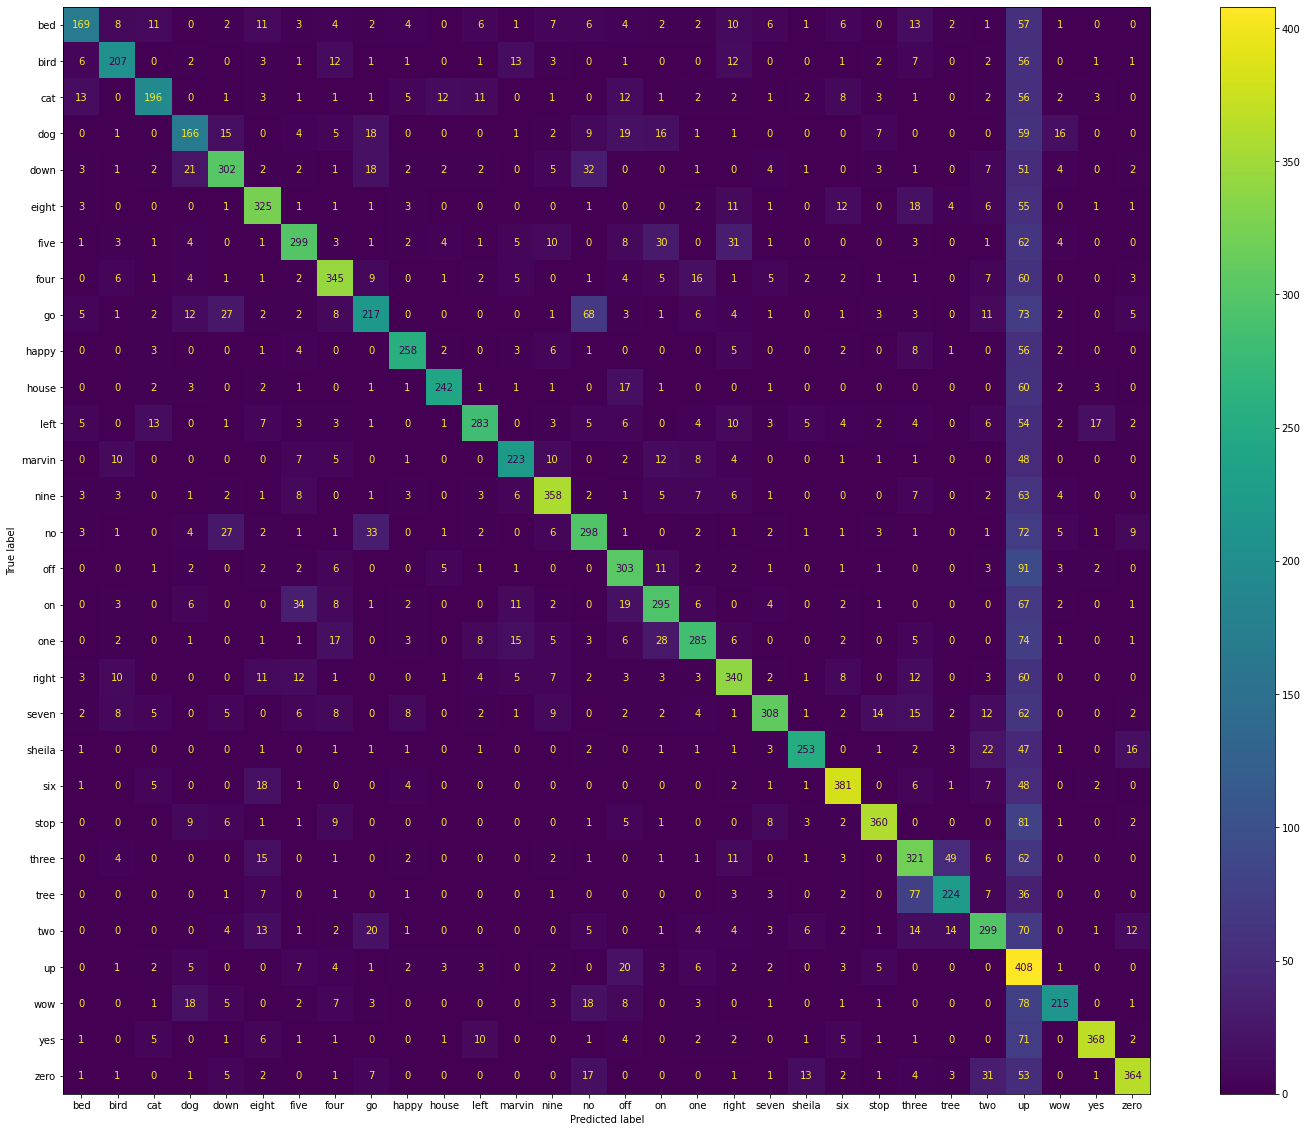

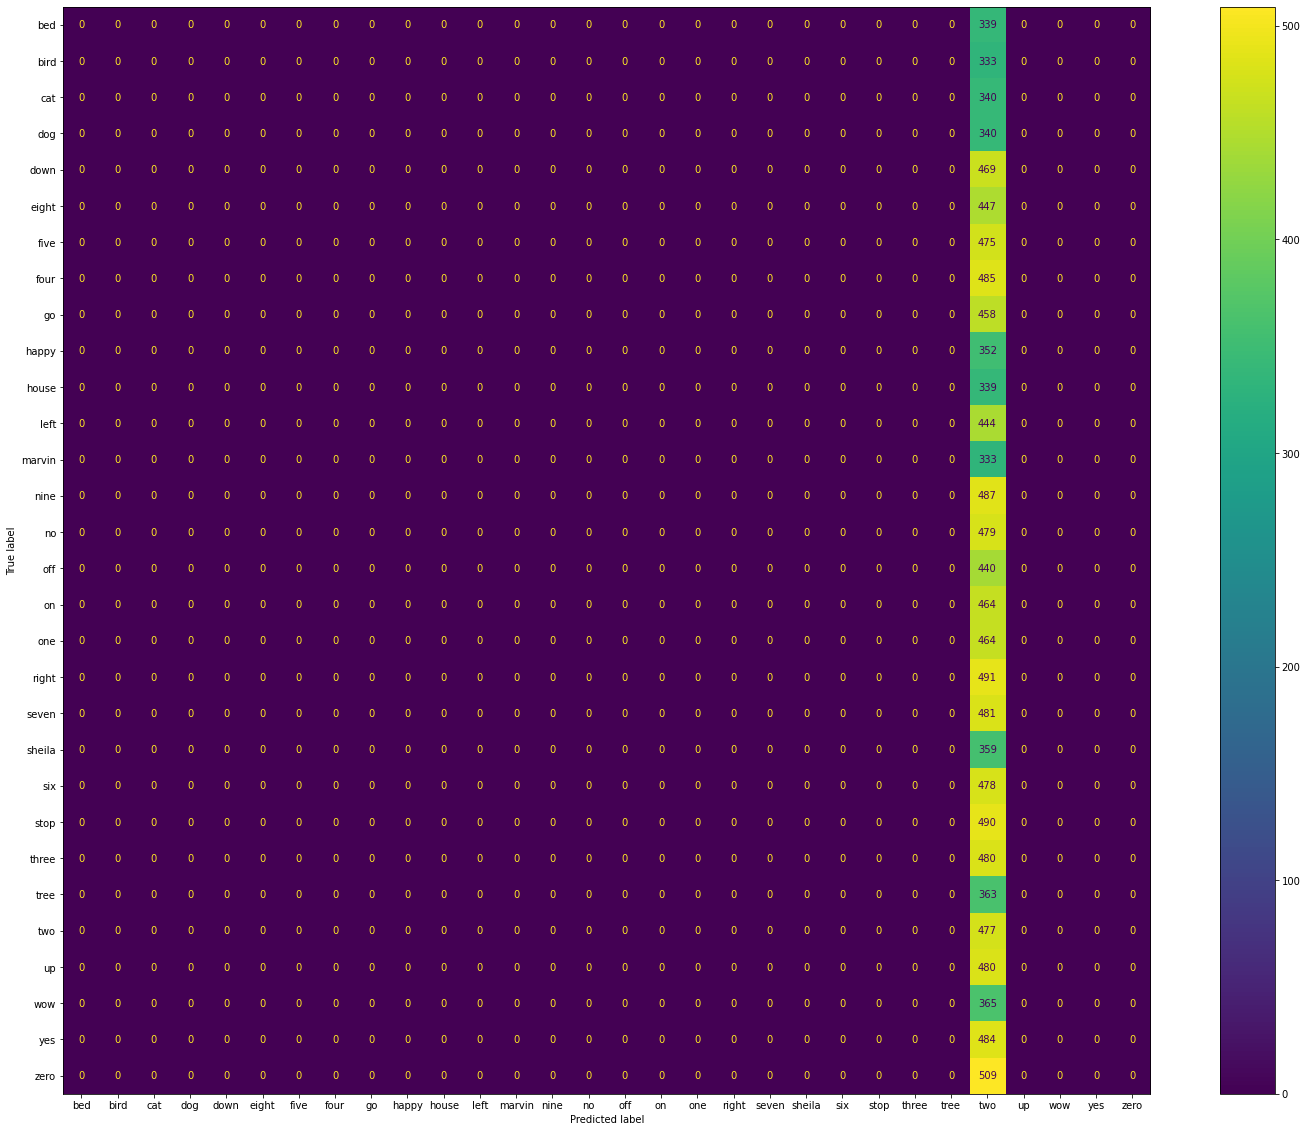

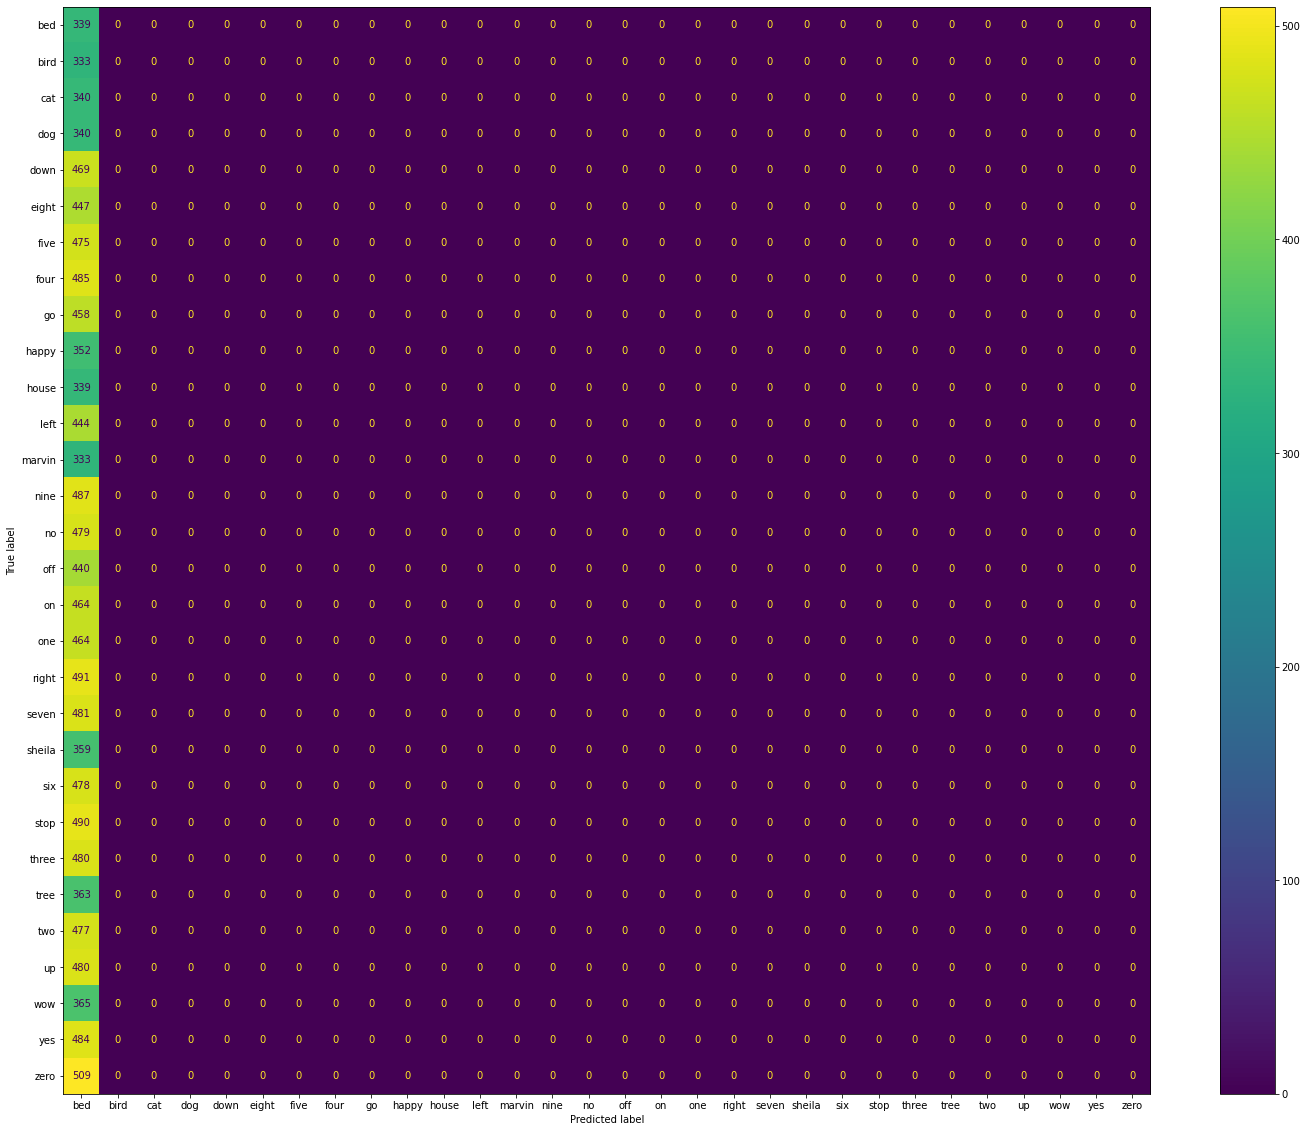

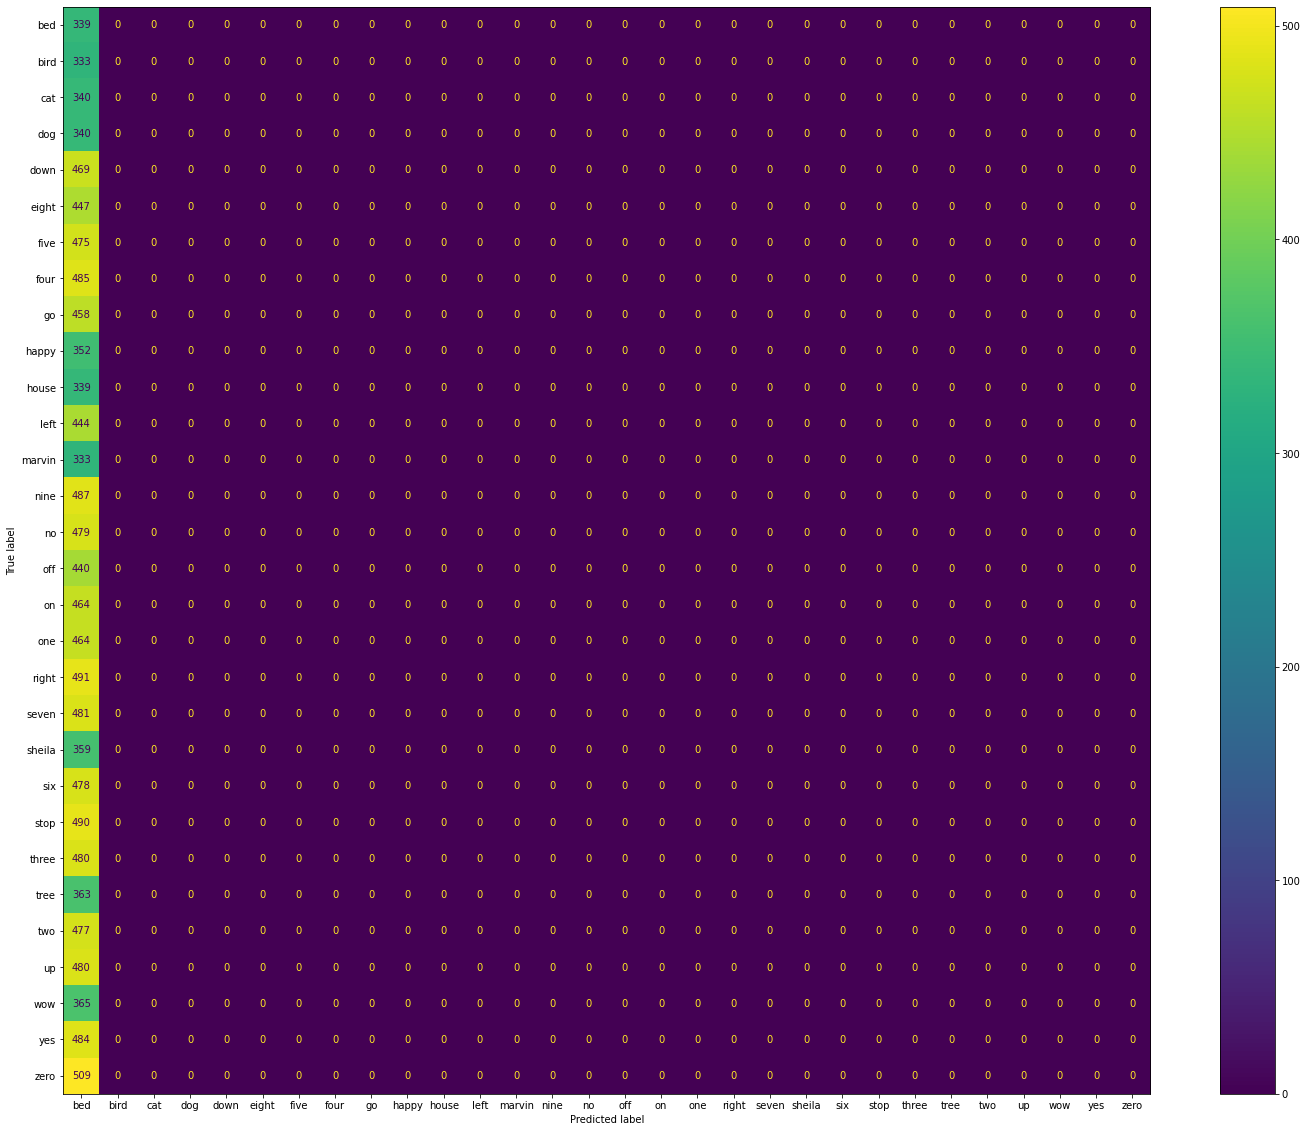

In [112]:
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = CNNet()
    model.load_state_dict(torch.load('models/' + str(lr) + '.pth'))
    model.eval()

    xd = return_cm(test_dataloader, model)

    disp = ConfusionMatrixDisplay(xd, display_labels=dataset.classes)
    fig, ax = plt.subplots(figsize=(25, 20))
    disp.plot(ax=ax)
    plt.savefig('./results/cm' + str(lr) +'.png')

In [113]:
model.eval()

CNNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=51136, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
)